In [1]:
from sklearn.metrics import accuracy_score

classification_names = {
    0: 'cloth',
    1: 'shoe',
    2: 'bag',
    3: 'pants',
    4: 'watch'
}


In [3]:
import os
import re
import numpy as np
import pandas as pd

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split



In [6]:
def sorted_alphanum(img_names):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda img_name: [convert(x) for x in re.split(r'([0-9]+)', img_name)]
    return sorted(img_names, key=alphanum_key)

class ImageLabelDataSet(Dataset):
    def __init__(self, image_dir, transform=None):
        super(ImageLabelDataSet, self).__init__()
        self.main_dir = image_dir
        self.transform = transform
        self.image_names = sorted_alphanum(os.listdir(self.main_dir))
        self.labels = pd.read_csv("../common/fashion-labels.csv")
        self.label_dict = dict(zip(self.labels['id'], self.labels['target']))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_loc = os.path.join(self.main_dir, self.image_names[idx])
        image = Image.open(image_loc).convert('RGB')
        if self.transform is not None:
            tenser_img = self.transform(image)
        else:
            raise ValueError("transform is not defined")

        label = self.label_dict[idx]
        return tenser_img, label

In [7]:
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

full_dataset = ImageLabelDataSet(image_dir="../common/dataset/", transform=transform)

print(len(full_dataset))

24853


In [8]:
from torch.utils.data import random_split
train_set, test_set = random_split(full_dataset, [0.75, 0.25])

In [9]:
batch_size = 32
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size
)

In [10]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(in_features=16 * 16 * 16, out_features=5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        return x

In [11]:
model = Classifier()
print(model)

Classifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=4096, out_features=5, bias=True)
)


In [13]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

In [15]:
output = model(images)
print(output.shape)

torch.Size([32, 5])


In [18]:
import torch.nn as nn

class Classifier1(nn.Module):
    def __init__(self):
        super(Classifier1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=16 * 16 * 16, out_features=5),
        )

    def forward(self, x):
        return self.model(x)

In [19]:
model1 = Classifier1()
print(model1)

Classifier1(
  (model): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=5, bias=True)
  )
)


In [20]:
output = model1(images)
print(output.shape)

torch.Size([32, 5])


In [24]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
model.to(device)

Classifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=4096, out_features=5, bias=True)
)

In [26]:
for epoch in range(num_epochs):
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss_val = loss(outputs, labels)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        train_loss += loss_val.item()
    this_loss = train_loss / len(train_loader)
    print("epoch: {}, loss: {}".format(epoch, this_loss))

epoch: 0, loss: 0.2403306785612479
epoch: 1, loss: 0.07529090240272082
epoch: 2, loss: 0.058817903985788636
epoch: 3, loss: 0.04880138850971717
epoch: 4, loss: 0.04114227659573368
epoch: 5, loss: 0.03544949181995469
epoch: 6, loss: 0.02992591474391055
epoch: 7, loss: 0.026465486769147496
epoch: 8, loss: 0.023618115701238007
epoch: 9, loss: 0.018049709604849366


In [33]:
loader_iter = iter(test_loader)
images, labels = next(loader_iter)
print(images.shape)

torch.Size([32, 3, 64, 64])


In [34]:
model.to(device)
images = images.to(device)
outputs = model(images)
outputs = outputs.cpu().detach().numpy()
print(outputs.shape)

(32, 5)


In [35]:
images = images.permute(0, 2, 3, 1).cpu().detach().numpy()
print(images.shape)

(32, 64, 64, 3)


class_pred: shoe
class_pred: watch
class_pred: shoe
class_pred: bag
class_pred: shoe
class_pred: cloth
class_pred: cloth
class_pred: cloth
class_pred: cloth
class_pred: shoe


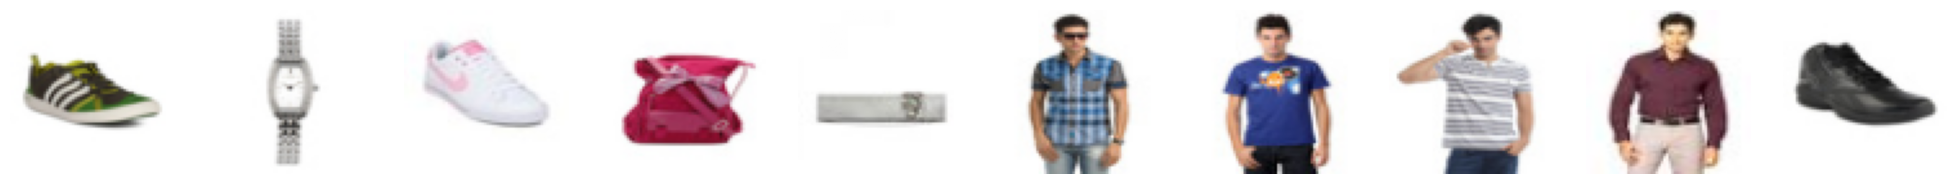

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(25, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
    y_pred = outputs[i]
    class_pred = np.argmax(y_pred)
    print("class_pred: {}".format(classification_names[class_pred]))
plt.show()

In [43]:
test_correct_num = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        y_pred = outputs.argmax(dim=1)
        test_correct_num += y_pred.eq(labels).sum().item()
accuracy = test_correct_num / len(test_set)
print("test accuracy: {}".format(accuracy))

test accuracy: 0.9893771125060358
